In [1]:
import re
import pandas as pd
import bs4
import requests
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

from spacy.matcher import Matcher 
from spacy.tokens import Span 

import networkx as nx

import matplotlib.pyplot as plt
from tqdm import tqdm

pd.set_option('display.max_colwidth', 200)
%matplotlib inline

2023-08-04 10:22:51.628076: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-04 10:22:51.680422: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-04 10:22:52.798090: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-08-04 10:22:53.806517: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at http

In [2]:
# import wikipedia sentences
candidate_sentences = pd.read_csv("/var/basefolder_smit/largelm/localdata/wiki_sentences_v2.csv")
candidate_sentences.shape

(4318, 1)

In [3]:
candidate_sentences['sentence'].sample(5)

1429                                i think there's all kinds of questions raised...
1419                                                he was also influenced by films:
11      m global was also circling to bid for the film's international sales rights.
3912                                          prabhas is terrific as father and son.
3641                 simulated male and female genitals are shown in various scenes.
Name: sentence, dtype: object

In [4]:

def get_entities(sent):
  ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  #############################################################
  
  for tok in nlp(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      
      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
        
      ## chunk 5  
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text
  #############################################################

  return [ent1.strip(), ent2.strip()]

In [5]:
get_entities("the film had 200 patents")

['film', '200  patents']

In [6]:
entity_pairs = []

for i in tqdm(candidate_sentences["sentence"]):
  entity_pairs.append(get_entities(i))

100%|██████████| 4318/4318 [00:27<00:00, 154.42it/s]


In [7]:
entity_pairs[10:20]


[['we', 'tests'],
 ['m', 'international sales rights'],
 ['canadian musician robbie robertson', 'soundtrack'],
 ['it', 'original music tracks'],
 ['it', 'reviewed  franchise'],
 ['she', 'accidentally  mystique'],
 ['military  forces', 'arrest'],
 ['train', 'vuk'],
 ['kota eberhardt', 'telepath selene gallio'],
 ['singer', 'men']]

In [8]:
def get_relation(sent):

  doc = nlp(sent)

  # Matcher class object 
  matcher = Matcher(nlp.vocab)

  #define the pattern 
  pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

  matcher.add("matching_1", [pattern], on_match = None)  

  matches = matcher(doc)
  k = len(matches) - 1

  span = doc[matches[k][1]:matches[k][2]] 

  return(span.text)

In [9]:
get_relation("John completed the task")

'completed'

In [10]:
relations = [get_relation(i) for i in tqdm(candidate_sentences['sentence'])]


100%|██████████| 4318/4318 [00:28<00:00, 152.76it/s]


In [11]:
pd.Series(relations).value_counts()[:50]


is               364
was              308
released on       90
are               74
include           73
were              68
released          41
's                39
composed by       34
became            31
have              31
has               30
become            28
released in       27
included          23
had               21
produced          21
been              20
called            19
used              19
considered        18
made              18
scheduled         17
be                17
directed by       16
stars             16
hired             14
produced by       14
written by        13
wrote             13
received          13
introduced in     13
went              13
wanted            12
sold              12
began in          11
set               11
began             11
cast as           11
won               11
gave              10
directed          10
includes          10
gives              9
going              9
produced in        9
opened             9
features     

In [12]:
# extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

In [13]:
# create a directed-graph from a dataframe
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

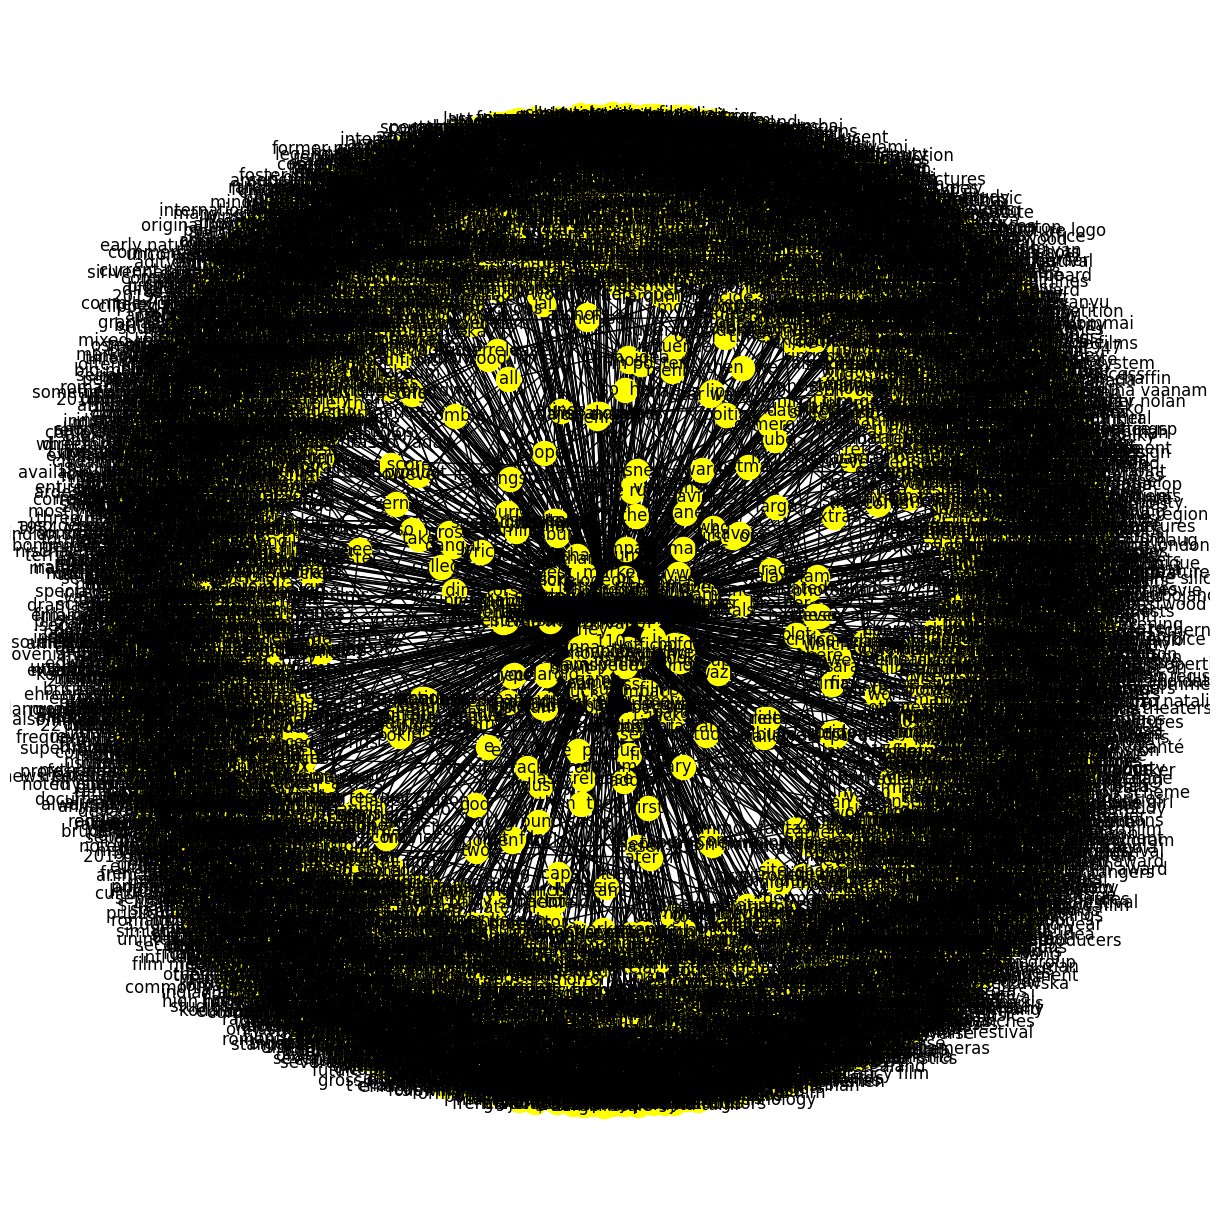

In [14]:
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='yellow', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

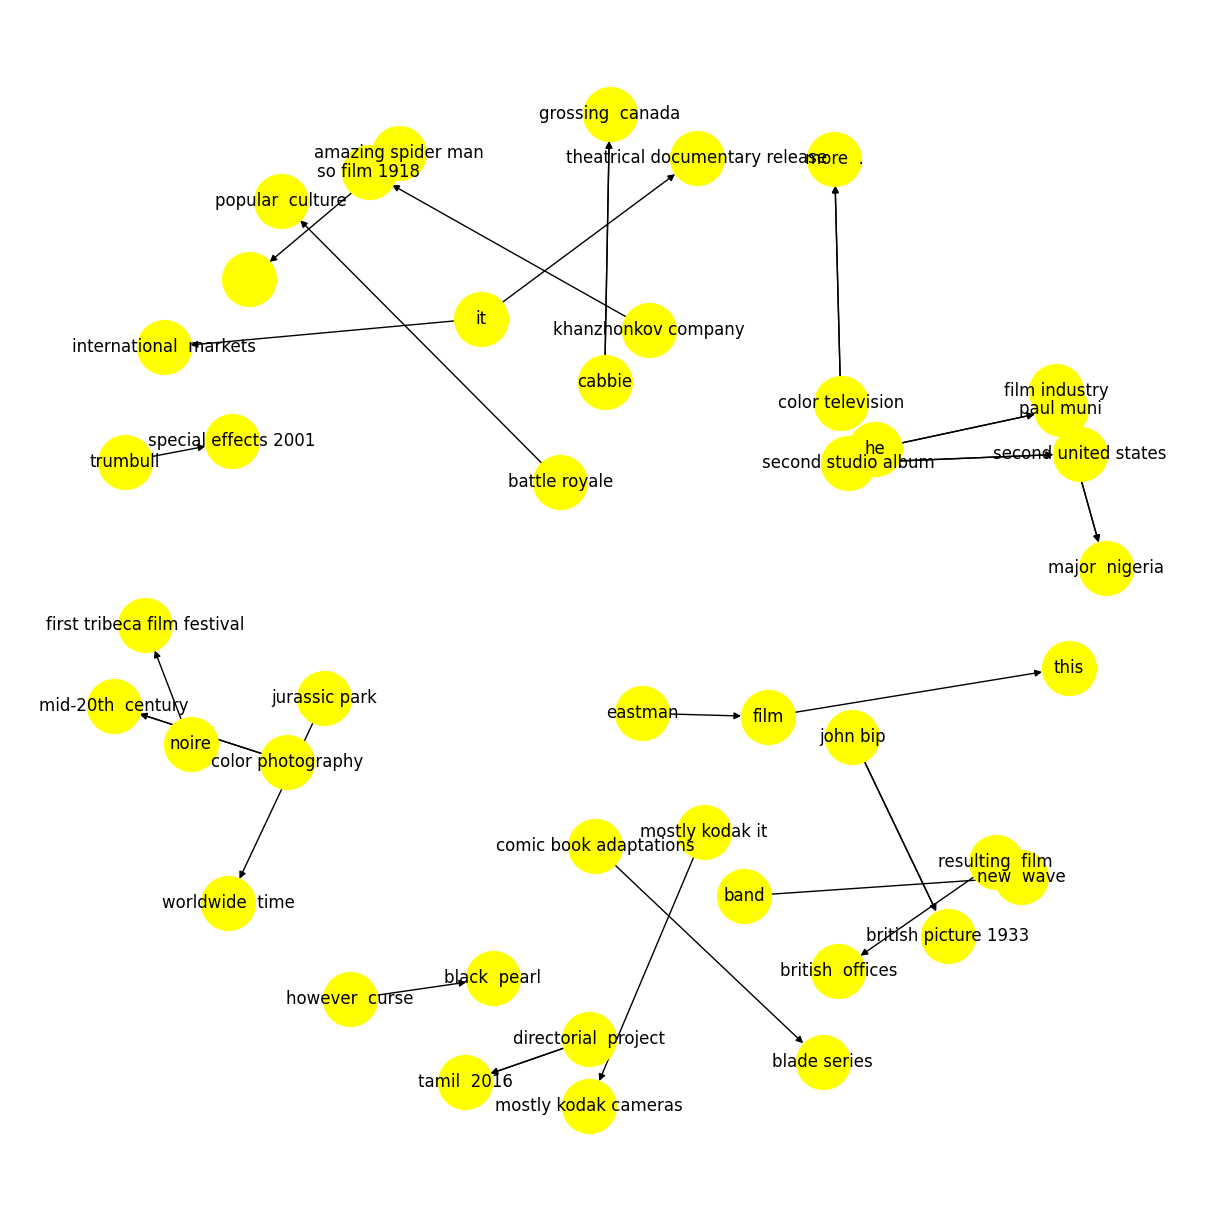

In [15]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="became"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='yellow', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

In [16]:
# Import Libraries

import tensorflow as tf
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [17]:
kg_df

source                           target          edge
0                connie                              own       decides
1         later  scream                         distance      heard in
2             christian                      then  elder  paralyzed by
3                temple                             fire        set on
4                                       outside cult him    wails with
...                 ...                              ...           ...
4313       confidencial                 negatively  film     responded
4314        le parisien                 five star rating          gave
4315  museum collection               37,000 film titles      includes
4316        predecessor             historical film 1946           was
4317                     1920'sfilmstar alexander binder      garbo by

[4318 rows x 3 columns]

In [18]:
f = open("myfile.txt", "w+")

In [19]:
for i in candidate_sentences['sentence']:
    print(i)

confused and frustrated, connie decides to leave on her own.
later, a woman’s scream is heard in the distance.
christian is then paralyzed by an elder.
the temple is set on fire.
outside, the cult wails with him.
it's a parable of a woman's religious awakening—
c. mackenzie, and craig vincent joined the cast.
later, craig di francia and action bronson were revealed to have joined the cast.
sebastian maniscalco and paul ben-victor were later revealed as being part of the cast.
we just tried to make the film.
we went through all these tests and things  
m global was also circling to bid for the film's international sales rights.
canadian musician robbie robertson supervised the soundtrack.
it features both original and existing music tracks.
it is the worst reviewed film in the franchise.
but she injures quicksilver and accidentally kills mystique before flying away.
military forces tasked with her arrest.
the train is attacked by vuk and her d'bari forces.
kota eberhardt portrays telepa

In [20]:
f.writelines(candidate_sentences['sentence'])

In [21]:
newdb = pd.read_csv("/var/basefolder_smit/largelm/knowledge-graph/data/output/kg/input_data.txt-out.csv")

In [22]:
newdb

she        injures   \
0                         woman            has    
1                        singer         direct    
2                        him.it           with    
3                      features       portrays    
4                         woman             of    
...                          ...            ...   
10478  apartment block.the film    operates on    
10479         j. joe pantoliano            had    
10480               him.deckard          leave    
10481         j. joe pantoliano            had    
10482           deckard returns          kills    

                                           quicksilver  
0                                               scream  
1                                                x-men  
2                       parable of religious awakening  
3                               telepath selene gallio  
4                                  religious awakening  
...                                                ...  
10478   multiple levels.the film 's inherent ambiguity  
10479                        had considered for role.i  
10480                                          rachael  
10481                           had earlier considered  
10482                                   have permitted  

[10483 rows x 3 columns]

In [23]:
newdb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10483 entries, 0 to 10482
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   she           10483 non-null  object
 1    injures      10483 non-null  object
 2    quicksilver  10483 non-null  object
dtypes: object(3)
memory usage: 245.8+ KB


In [24]:
newdb.keys

<bound method NDFrame.keys of                             she        injures   \
0                         woman            has    
1                        singer         direct    
2                        him.it           with    
3                      features       portrays    
4                         woman             of    
...                          ...            ...   
10478  apartment block.the film    operates on    
10479         j. joe pantoliano            had    
10480               him.deckard          leave    
10481         j. joe pantoliano            had    
10482           deckard returns          kills    

                                           quicksilver  
0                                               scream  
1                                                x-men  
2                       parable of religious awakening  
3                               telepath selene gallio  
4                                  religious awakening  
...            

In [25]:
newdb[' injures ']

0                 has 
1              direct 
2                with 
3            portrays 
4                  of 
             ...      
10478     operates on 
10479             had 
10480           leave 
10481             had 
10482           kills 
Name:  injures , Length: 10483, dtype: object

In [26]:
newdb[' quicksilver']

0                                                 scream
1                                                  x-men
2                         parable of religious awakening
3                                 telepath selene gallio
4                                    religious awakening
                              ...                       
10478     multiple levels.the film 's inherent ambiguity
10479                          had considered for role.i
10480                                            rachael
10481                             had earlier considered
10482                                     have permitted
Name:  quicksilver, Length: 10483, dtype: object

In [27]:
newdb['she ']

0                           woman 
1                          singer 
2                          him.it 
3                        features 
4                           woman 
                   ...            
10478    apartment block.the film 
10479           j. joe pantoliano 
10480                 him.deckard 
10481           j. joe pantoliano 
10482             deckard returns 
Name: she , Length: 10483, dtype: object

In [28]:
newer_df = pd.DataFrame({'source':newdb['she '], 'target':newdb[' quicksilver'], 'edge':newdb[' injures ']})

In [29]:
newer_df

source  \
0                         woman    
1                        singer    
2                        him.it    
3                      features    
4                         woman    
...                          ...   
10478  apartment block.the film    
10479         j. joe pantoliano    
10480               him.deckard    
10481         j. joe pantoliano    
10482           deckard returns    

                                                target           edge  
0                                               scream           has   
1                                                x-men        direct   
2                       parable of religious awakening          with   
3                               telepath selene gallio      portrays   
4                                  religious awakening            of   
...                                                ...            ...  
10478   multiple levels.the film 's inherent ambiguity   operates on   
10479                        had considered for role.i           had   
10480                                          rachael         leave   
10481                           had earlier considered           had   
10482                                   have permitted         kills   

[10483 rows x 3 columns]

In [30]:
# create a directed-graph from a dataframe
G2=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

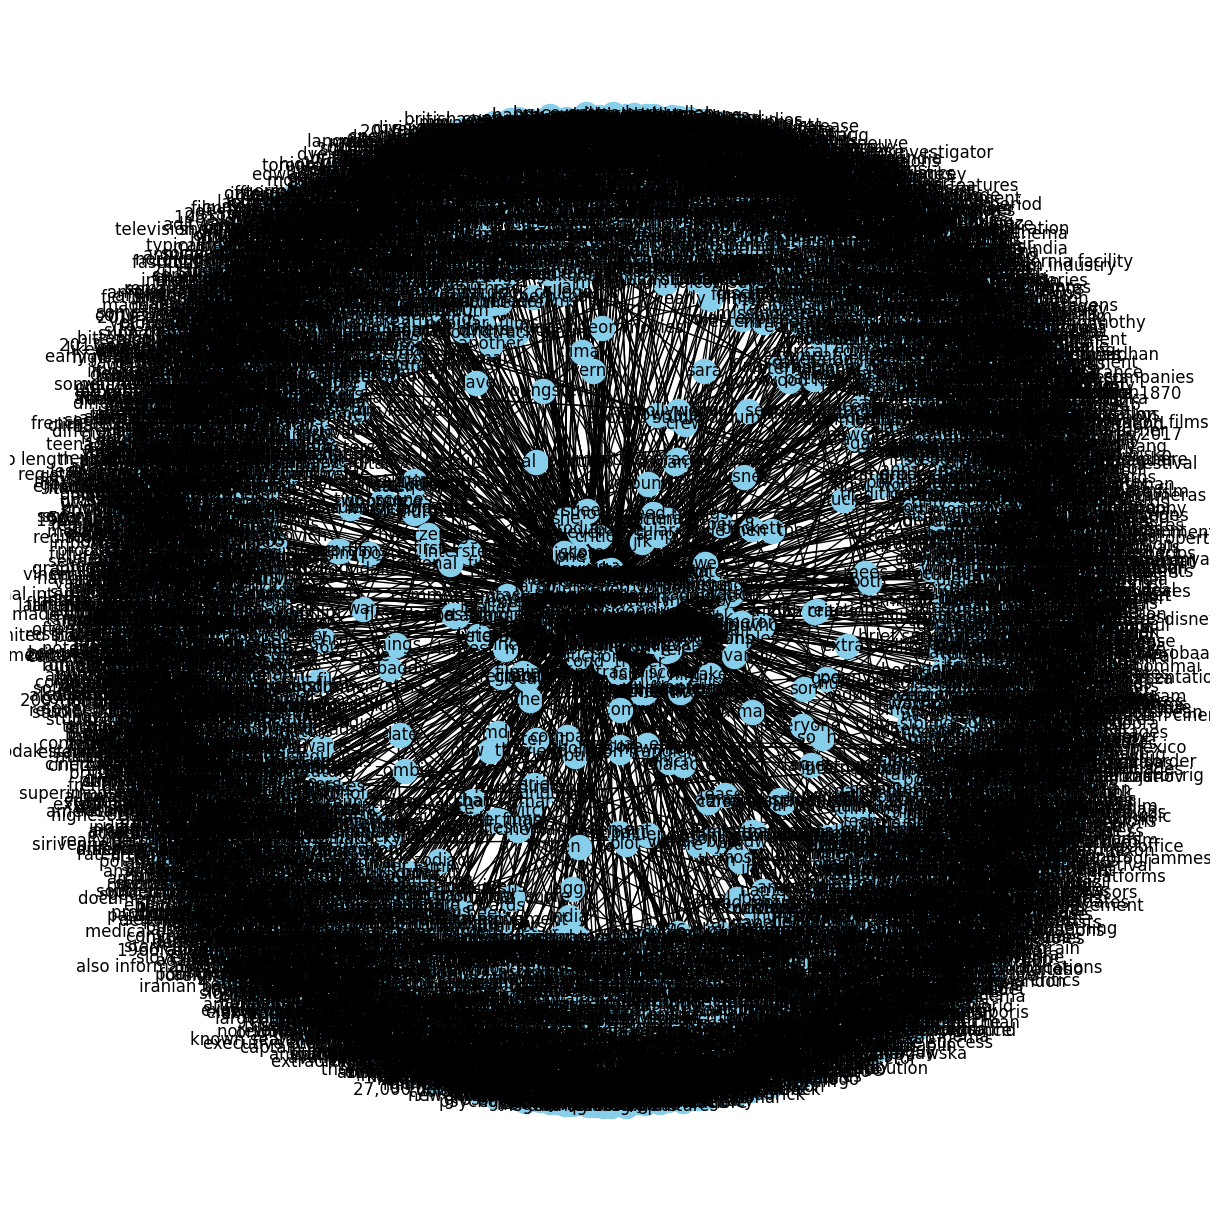

In [31]:
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G2)
nx.draw(G2, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

In [32]:
pd.Series(newer_df['edge']).value_counts()[:50]

edge
 was                          1825
 is                           1054
 has                           281
 were                          274
 are                           256
 is in                         128
 be                            128
 responded                     128
 became                        125
 have                          114
 was released on                85
 directed by                    75
 was departure from             74
 can                            64
 is occupied by                 64
 is now occupied by             64
 sometimes have                 64
 include                        63
 released                       58
 will                           54
 received                       54
 were discontinued from         48
 tipsy                          48
 topsy                          48
 turvy                          48
 was selected                   45
 been                           35
 set                            34
 is considered 

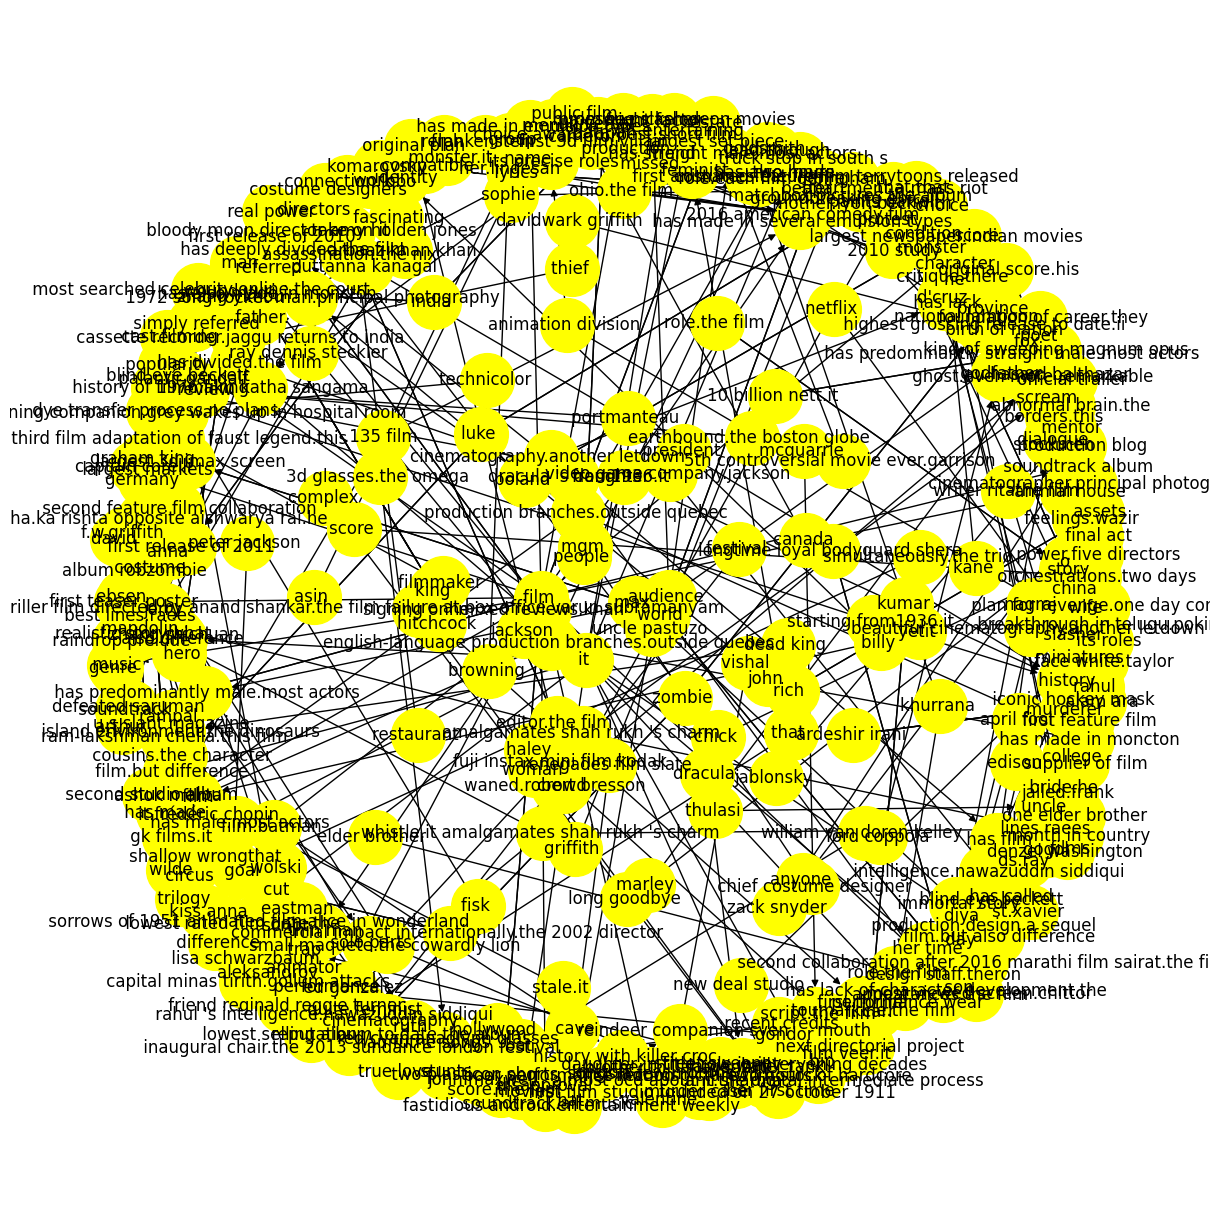

In [33]:
G3=nx.from_pandas_edgelist(newer_df[newer_df['edge']==newer_df['edge'][0]], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G3, k = 0.5) # k regulates the distance between nodes
nx.draw(G3, with_labels=True, node_color='yellow', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

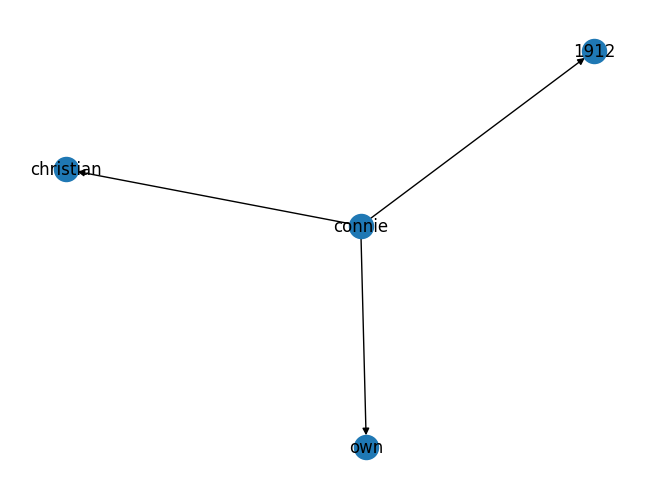

In [43]:
x = 'connie'

neighbor_nodes = list(G2.neighbors(x)) # get the list of neighbors of node n
neighbor_nodes.append(x) # add node n to the list
H = G2.subgraph(neighbor_nodes)

nx.draw(H, with_labels=True) # draw the subgraph with node labels
plt.show()

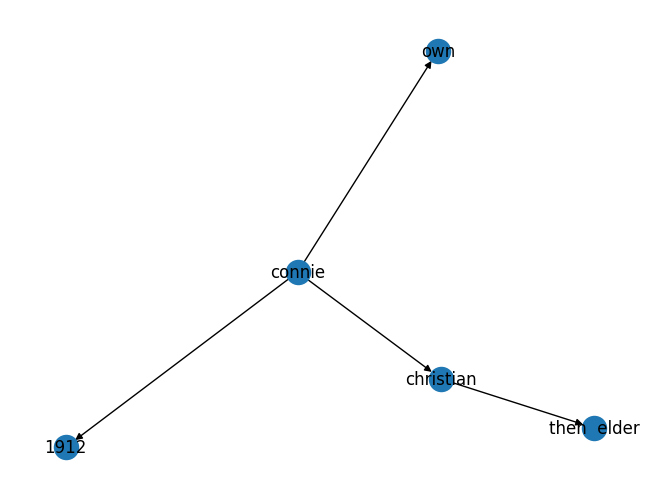

In [44]:
neighbor_nodes = list(G2.neighbors('connie'))

for i in neighbor_nodes:
    neighbor_nodes_temp = list(G2.neighbors(i)) # get the list of neighbors of node n
    neighbor_nodes_temp.append(i)

    htemp = G2.subgraph(neighbor_nodes_temp)

    H = nx.compose(H, htemp)
    neighbor_nodes_temp = []

nx.draw(H, with_labels=True) # draw the subgraph with node labels
plt.show()

In [ ]:
list(G2.nodes)

In [39]:
G2.add_edge('connie', 'christian', label = 'is')

0

In [40]:
G2.add_edge('connie', '1912', label = 'is alive in')

0